In [ ]:
!pip install --upgrade --force-reinstall --no-cache-dir \
  transformers==4.37.2 \
  accelerate==0.25.0 \
  peft==0.8.2 \
  datasets \
  evaluate \
  seqeval


In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
from datasets import load_dataset, DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
import numpy as np
import evaluate

# Entity tag mappings
labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}


In [ ]:
import torch
print(torch.cuda.is_available())


In [ ]:
def load_conll(path):
    tokens, labels = [], []
    sentence_tokens, sentence_labels = [], []

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence_tokens:
                    tokens.append(sentence_tokens)
                    labels.append(sentence_labels)
                    sentence_tokens, sentence_labels = [], []
            else:
                splits = line.split()
                sentence_tokens.append(splits[0])
                sentence_labels.append(splits[1])
    return {"tokens": tokens, "ner_tags": labels}

dataset = DatasetDict({
    "train": Dataset.from_dict(load_conll("/kaggle/input/masakha/train.conll")),
    "validation": Dataset.from_dict(load_conll("/kaggle/input/masakha/dev.conll")),
    "test": Dataset.from_dict(load_conll("/kaggle/input/masakha/test.conll"))
})




In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base", use_fast=True)

def tokenize_and_align_labels(examples):
    tokenized = tokenizer(examples["tokens"], is_split_into_words=True, truncation=True, padding="max_length")
    labels = []

    for i, label_seq in enumerate(examples["ner_tags"]):
        word_ids = tokenized.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label2id[label_seq[word_idx]])
            else:
                label_ids.append(label2id[label_seq[word_idx]])
            previous_word_idx = word_idx

        labels.append(label_ids)
    
    tokenized["labels"] = labels
    return tokenized

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)


In [ ]:
seqeval = evaluate.load("seqeval")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_preds = [[id2label[p] for (p, l) in zip(pred, label) if l != -100]
                  for pred, label in zip(predictions, labels)]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [ ]:
print(f"Train size: {len(tokenized_dataset['train'])}")
print(f"Eval size : {len(tokenized_dataset['validation'])}")


In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

args = TrainingArguments(
    output_dir="../models/xlmr_masakha_baseline",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="../logs",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics
)

trainer.train()


In [ ]:
trainer.evaluate()
trainer.save_model("twi-ner-xlmr")
tokenizer.save_pretrained("twi-ner-xlmr")


In [ ]:
trainer.save_model("twi_xlmr_model")              
tokenizer.save_pretrained("twi_xlmr_model")       


In [ ]:
!zip -r twi_xlmr_model.zip twi_xlmr_model


In [ ]:
!pip install numpy==1.24.4 --force-reinstall


In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("twi_xlmr_model")
model = AutoModelForTokenClassification.from_pretrained("twi_xlmr_model")


In [6]:
!unzip -o twi_xlmr_model.zip -d .


Archive:  twi_xlmr_model.zip
  inflating: ./twi_xlmr_model/tokenizer_config.json  
  inflating: ./twi_xlmr_model/sentencepiece.bpe.model  
  inflating: ./twi_xlmr_model/config.json  
  inflating: ./twi_xlmr_model/model.safetensors  
  inflating: ./twi_xlmr_model/tokenizer.json  
  inflating: ./twi_xlmr_model/special_tokens_map.json  
  inflating: ./twi_xlmr_model/training_args.bin  


In [7]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_path = "./twi_xlmr_model"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)


In [8]:
from datasets import load_dataset

dataset = load_dataset("masakhane/masakhaner2", name="twi")


README.md:   0%|          | 0.00/8.62k [00:00<?, ?B/s]

masakhaner2.py:   0%|          | 0.00/8.79k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/367k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4240 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/605 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1211 [00:00<?, ? examples/s]

In [13]:
from datasets import load_dataset

dataset = load_dataset("masakhane/masakhaner2", name="twi")
val_dataset = dataset["validation"]


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding=True,
        is_split_into_words=True
    )

    labels = []
    for i, label_seq in enumerate(examples["ner_tags"]):  
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label_seq[word_idx])
            else:
                label_ids.append(label_seq[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [27]:
labels = ['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-DATE', 'I-DATE']
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}


In [30]:
tokenized_val = dataset["validation"].map(tokenize_and_align_labels, batched=True)
results = trainer.evaluate(tokenized_val)
print(results)


Map:   0%|          | 0/605 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.04564737156033516, 'eval_precision': 0.7628062360801782, 'eval_recall': 0.86489898989899, 'eval_f1': 0.8106508875739645, 'eval_accuracy': 0.9878473800648544, 'eval_runtime': 7.4929, 'eval_samples_per_second': 80.744, 'eval_steps_per_second': 5.071}


In [31]:
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[l] for l in label if l != -100] for label in labels]
    true_preds  = [[id2label[p] for (p, l) in zip(pred, label) if l != -100] 
                   for pred, label in zip(predictions, labels)]

    results = seqeval.compute(predictions=true_preds, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


In [32]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

results = trainer.evaluate(tokenized_val)
print(results)


{'eval_loss': 0.04564737156033516, 'eval_precision': 0.7628062360801782, 'eval_recall': 0.86489898989899, 'eval_f1': 0.8106508875739645, 'eval_accuracy': 0.9878473800648544, 'eval_runtime': 6.4922, 'eval_samples_per_second': 93.189, 'eval_steps_per_second': 5.853}


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

print("Available columns:", list(logs.columns))

# Drop steps without eval metrics
metric_cols = [col for col in ["eval_loss", "eval_f1", "eval_precision", "eval_recall"] if col in logs.columns]
logs = logs.dropna(subset=metric_cols)

logs.head()


Available columns: ['eval_loss', 'eval_precision', 'eval_recall', 'eval_f1', 'eval_accuracy', 'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second', 'step']


,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,step
0,0.045647,0.762806,0.864899,0.810651,0.987847,6.4922,93.189,5.853,0


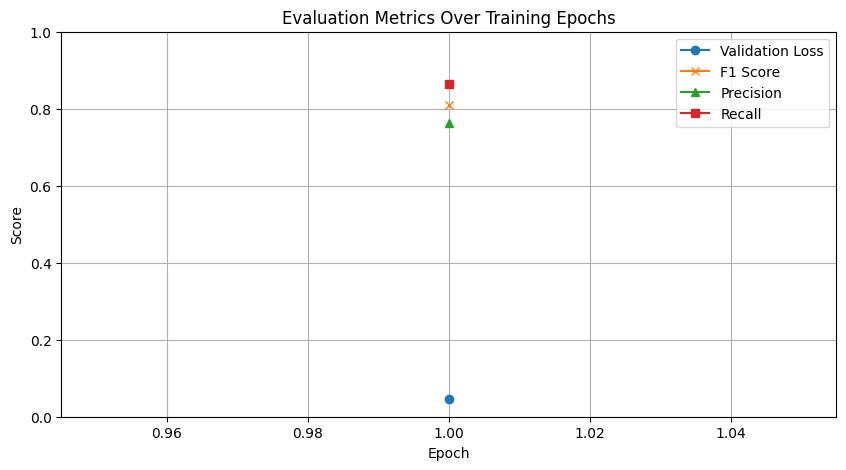

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = pd.DataFrame(trainer.state.log_history)

metric_cols = [col for col in ["eval_loss", "eval_f1", "eval_precision", "eval_recall"] if col in logs.columns]
logs = logs.dropna(subset=metric_cols).reset_index(drop=True)

logs["epoch"] = logs.index + 1

plt.figure(figsize=(10, 5))
if "eval_loss" in logs:
    plt.plot(logs["epoch"], logs["eval_loss"], label="Validation Loss", marker='o')
if "eval_f1" in logs:
    plt.plot(logs["epoch"], logs["eval_f1"], label="F1 Score", marker='x')
if "eval_precision" in logs:
    plt.plot(logs["epoch"], logs["eval_precision"], label="Precision", marker='^')
if "eval_recall" in logs:
    plt.plot(logs["epoch"], logs["eval_recall"], label="Recall", marker='s')

plt.title("Evaluation Metrics Over Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()


In [38]:
plt.savefig("eval_metrics_plot.png", dpi=300, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>

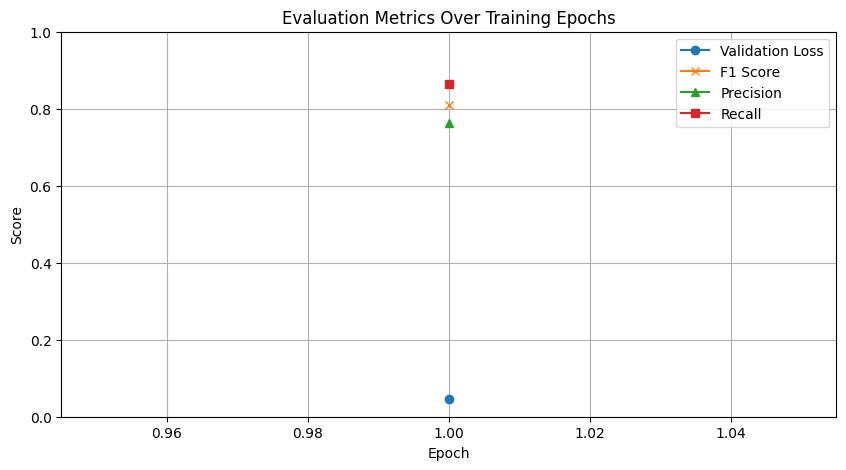

In [39]:
plt.figure(figsize=(10, 5))
if "eval_loss" in logs:
    plt.plot(logs["epoch"], logs["eval_loss"], label="Validation Loss", marker='o')
if "eval_f1" in logs:
    plt.plot(logs["epoch"], logs["eval_f1"], label="F1 Score", marker='x')
if "eval_precision" in logs:
    plt.plot(logs["epoch"], logs["eval_precision"], label="Precision", marker='^')
if "eval_recall" in logs:
    plt.plot(logs["epoch"], logs["eval_recall"], label="Recall", marker='s')

plt.title("Evaluation Metrics Over Training Epochs")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.savefig("eval_metrics_plot.png", dpi=300, bbox_inches="tight")
